# <b> Hybrid Defenses on Data Poisoning </b>

<ins>Purpose</ins>: The goal of this project is to compare and contrast KMeans and PCA as defenses against Gradient Matching, which will serve as our attack algorithm

---



In [ ]:
# import libraries
import numpy as np
import torch
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import time

## Gradient Matching (Attack)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils as utils
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
###Import dataset
def reshape_image(x):
    return x.repeat(3, 1, 1)

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((28,28)),
                                transforms.Lambda(reshape_image),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

###train set loading
trainset = datasets.MNIST(root='./data',
                          train=True,
                          download=True,
                          transform=transform)

trainloader = utils.data.DataLoader(trainset,
                                    batch_size=128,
                                    shuffle=True,
                                    num_workers=0)

###test set loading
testset = datasets.MNIST(root='./data',
                         train=False,
                         download=True,
                         transform=transform)

testloader = utils.data.DataLoader(testset,
                                   batch_size=128,
                                   shuffle=False,
                                   num_workers=0)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 14.9MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 491kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.58MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.65MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
###custom model
class customNet(nn.Module):
    def __init__(self):
        super(customNet, self).__init__()

        ##Conv2d - input 3x28x28, ouput 32x28x28
        self.conv2d1 = nn.Conv2d(in_channels=3,
                                 out_channels=32,
                                 kernel_size=3,
                                 stride=1,
                                 padding=1)

        ##Maxpool - input 32x28x28, ouput 32x14x14
        self.maxpool1 = nn.MaxPool2d(kernel_size=2,
                                     stride=2,
                                     padding=0)

        ##Conv2d - input 32x14x14, ouput 64x14x14
        self.conv2d2 = nn.Conv2d(in_channels=32,
                                 out_channels=64,
                                 kernel_size=3,
                                 stride=1,
                                 padding=1)

        ##Maxpool - input 64x14x14, ouput 64x7x7
        self.maxpool2 = nn.MaxPool2d(kernel_size=2,
                                     stride=2,
                                     padding=0)

        ##Conv2d - input 64x7x7, ouput 128x5x5
        self.conv2d3 = nn.Conv2d(in_channels=64,
                                 out_channels=128,
                                 kernel_size=3,
                                 stride=1,
                                 padding=0)

        ##Maxpool - input 128x5x5, ouput 128x2x2
        self.maxpool3 = nn.MaxPool2d(kernel_size=3,
                                     stride=2,
                                     padding=0)

        self.linear1 = nn.Linear(128*2*2, 128)
        self.linear2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.maxpool1(F.relu(self.conv2d1(x)))
        x = self.maxpool2(F.relu(self.conv2d2(x)))
        x = self.maxpool3(F.relu(self.conv2d3(x)))
        x = x.view(-1, 128*2*2)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [ ]:
###Adversarial gradient attack data poisoning on trained data
def grad_attack_train(model, data, target, adv_class=None, adv_eps=0.25):
    ce_loss = nn.CrossEntropyLoss()
    adv_samples = None
    adv_labels = None

    for img, label in zip(data, target):
        if adv_class is not None:
            ###select images only from the given adversarial class
            adv_idx = (label==adv_class)
            img = img[adv_idx]
            label = label[adv_idx]
        else:
            adv_idx = (label!=adv_class)
            img = img[adv_idx]
            label = label[adv_idx]

        if len(img)==0:
            continue

        img.requires_grad = True
        out = model(img)
        loss = ce_loss(out, label.view(1))
        model.zero_grad()
        loss.backward()
        img_grad = img.grad.data
        img_data = img + adv_eps * img_grad.sign()
        #img_data = torch.clamp(img_data, 0, 1)

        if adv_samples is None:
            adv_samples = img_data
            adv_labels = label
        else:
            adv_samples = torch.cat((adv_samples, img_data), dim=0)
            adv_labels = torch.cat((adv_labels, label), dim=0)
            if not isinstance(adv_samples, torch.Tensor):
                raise TypeError(f"adv_samples should be a Tensor, {type(adv_samples)}")
            if not isinstance(adv_labels, torch.Tensor):
                raise TypeError(f"adv_labels should be a Tensor, {type(adv_labels)}")

    return adv_samples, adv_labels

In [ ]:
###train the model
def train_model(model, data, epoch=10, learning_rate=0.001, attack=False, adv_class=None, adv_eps=0.25):
    ce_loss = nn.CrossEntropyLoss()
    optim = torch.optim.Adam(model.parameters(),
                             lr=learning_rate)

    model.train()
    for e in range(epoch):
        run_loss, count = 0, 0
        for img, lbl in data:
            img = img.to(device)
            lbl = lbl.to(device)
            comb_img = img
            comb_lbl = lbl
            if attack:
                ###adversarial gradient attack for data poisoning
                adv_img, adv_lbl = grad_attack_train(model, img, lbl, adv_class, adv_eps)
                comb_img = torch.cat([img, adv_img])
                comb_lbl = torch.cat([lbl, adv_lbl])
            optim.zero_grad()
            out = model(comb_img)
            loss = ce_loss(out, comb_lbl)
            loss.backward()
            optim.step()
            count += 1
            run_loss += loss.item()

        print(f'Epoch: {e+1}, Loss: {run_loss/count:.4f}')

    return model

In [ ]:
###evaluate the model
def eval_model(model, data, adv_class):
    correct, adv_correct, adv_incorrect = 0, 0, 0
    total, adv_total = 0, 0
    features = []
    predict = []
    labels = []
    with torch.no_grad():
        for img, lbl in data:
            img = img.to(device)
            lbl = lbl.to(device)
            out = model(img)
            if len(features)==0:
                features = out.detach().cpu().numpy()
                labels = lbl.detach().cpu().numpy()
            else:
                features = np.concatenate((features, out.detach().cpu().numpy()))
                labels = np.concatenate((labels, lbl.detach().cpu().numpy()))
            _, pred = torch.max(out.data, 1)
            total += lbl.size(0)
            correct += (pred == lbl).sum().item()
            if len(predict)==0:
                predict = pred.detach().cpu().numpy()
            else:
                predict = np.concatenate((predict, pred.detach().cpu().numpy()))
    accuracy = 100 * correct / total

    adv_mask = (labels==adv_class)
    adv_label = predict[adv_mask]
    adv_original = labels[adv_mask]
    for a in range(len(adv_label)):
        adv_total += 1
        if adv_label[a] == adv_class and adv_original[a] == adv_class:
            adv_correct += 1
        elif adv_label[a] != adv_class and adv_original[a] == adv_class:
            adv_incorrect += 1
    adv_accuracy = 100 * adv_correct / adv_total
    adv_nonacuracy = 100 * adv_incorrect / adv_total

    return features, labels, accuracy, adv_accuracy, adv_nonacuracy

In [ ]:
###visualize the clusters
def display_clusters(data, n_clusters, process='before'):
    tsne = TSNE(n_components=2,
                random_state=42)
    tr_data = tsne.fit_transform(data)
    kmeans = KMeans(n_clusters=n_clusters,
                    random_state=42)
    kmeans.fit(tr_data)
    fig, ax = plt.subplots()
    scatter = ax.scatter(data[:, 0],
                         data[:, 1],
                         c=kmeans.labels_,
                         cmap='rainbow')
    leg = ax.legend(*scatter.legend_elements(),
                    loc="upper right")
    ax.add_artist(leg)
    if process == 'before':
        plt.title("Clusters before attack")
    else:
        plt.title("Clusters after attack")
    plt.show()

In [ ]:
###load custom model for training before adversarial gradient attack
model = customNet()
model.to(device)

###train and save the model
model = train_model(model, trainloader, epoch=10, learning_rate=0.001, attack=False)
torch.save(model.state_dict(), 'model_before_attack.pth')

Epoch: 1, Loss: 0.2383
Epoch: 2, Loss: 0.0503
Epoch: 3, Loss: 0.0339
Epoch: 4, Loss: 0.0265
Epoch: 5, Loss: 0.0209
Epoch: 6, Loss: 0.0187
Epoch: 7, Loss: 0.0136
Epoch: 8, Loss: 0.0130
Epoch: 9, Loss: 0.0123
Epoch: 10, Loss: 0.0110


Accuracy before attack for model: 99.22
Accuracy before attack for class (0): 99.8980 and total misclassification for class (0): 0.1020
Accuracy before attack for class (1): 99.9119 and total misclassification for class (1): 0.0881
Accuracy before attack for class (2): 99.6124 and total misclassification for class (2): 0.3876
Accuracy before attack for class (3): 99.2079 and total misclassification for class (3): 0.7921
Accuracy before attack for class (4): 99.6945 and total misclassification for class (4): 0.3055
Accuracy before attack for class (5): 99.1031 and total misclassification for class (5): 0.8969
Accuracy before attack for class (6): 99.2693 and total misclassification for class (6): 0.7307
Accuracy before attack for class (7): 97.5681 and total misclassification for class (7): 2.4319
Accuracy before attack for class (8): 99.6920 and total misclassification for class (8): 0.3080
Accuracy before attack for class (9): 98.2161 and total misclassification for class (9): 1.7839


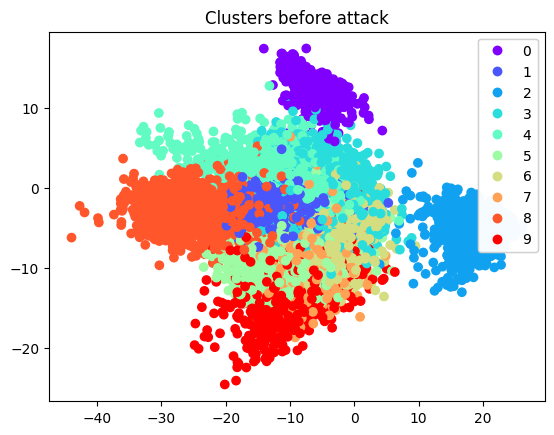

The total execution time for before the attack is : 120.18161463737488


In [ ]:
###evaluate the model before attack
start_time = time.time()
model.load_state_dict(torch.load('model_before_attack.pth', weights_only=False))
model_class = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
for i in model_class:
    model_features, model_labels, model_score, adv_model_score, adv_misclass = eval_model(model, testloader, i)
    if i==0:
        print(f'Accuracy before attack for model: {model_score}')
    print(f'Accuracy before attack for class ({i}): {adv_model_score:.4f} and total misclassification for class ({i}): {adv_misclass:.4f}')

###display the clusters before attack
display_clusters(torch.tensor(model_features), 10, process='before')
end_time = time.time()
print(f"The total execution time for before the attack is : {end_time - start_time}")

In [ ]:
###train and save the model after attack
model.load_state_dict(torch.load('model_before_attack.pth', weights_only=False))
model = train_model(model, trainloader, epoch=1, learning_rate=0.001,
                    attack=True, adv_class=None, adv_eps=2.00)
torch.save(model.state_dict(), 'model_after_attack.pth')

Epoch: 1, Loss: 0.6142


Accuracy after attack for model: 98.92
Accuracy after attack for class (0): 99.7959 and total misclassification for class (0): 0.2041
Accuracy after attack for class (1): 99.9119 and total misclassification for class (1): 0.0881
Accuracy after attack for class (2): 99.3217 and total misclassification for class (2): 0.6783
Accuracy after attack for class (3): 99.4059 and total misclassification for class (3): 0.5941
Accuracy after attack for class (4): 98.9817 and total misclassification for class (4): 1.0183
Accuracy after attack for class (5): 99.4395 and total misclassification for class (5): 0.5605
Accuracy after attack for class (6): 98.4342 and total misclassification for class (6): 1.5658
Accuracy after attack for class (7): 98.9300 and total misclassification for class (7): 1.0700
Accuracy after attack for class (8): 96.9199 and total misclassification for class (8): 3.0801
Accuracy after attack for class (9): 97.9187 and total misclassification for class (9): 2.0813


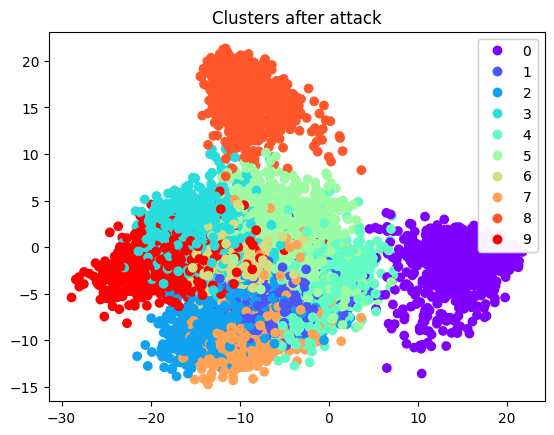

The total execution time for after the attack is: 118.2129054069519


In [ ]:
start_time = time.time()
###evaluate the model after attack
model.load_state_dict(torch.load('model_after_attack.pth', weights_only=False))
model_class = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
for i in model_class:
    model_features, model_labels, model_score, adv_model_score, adv_misclass = eval_model(model, testloader, i)
    if i==0:
        print(f'Accuracy after attack for model: {model_score}')
    print(f'Accuracy after attack for class ({i}): {adv_model_score:.4f} and total misclassification for class ({i}): {adv_misclass:.4f}')

###display the clusters after attack
display_clusters(torch.tensor(model_features), 10, process='after')
end_time = time.time()
print(f"The total execution time for after the attack is: {end_time - start_time}")

## KMeans Clustering (Defense 1)

In [ ]:
def kmeans_defense(model, data_loader, num_clusters=10, threshold=None):

  # Extract features
  features, labels, _, _, _ = eval_model(model, data_loader, 0)  # adv_class doesn't matter here

  # Apply KMeans
  kmeans = KMeans(n_clusters=num_clusters, random_state=42)
  kmeans_labels = kmeans.fit_predict(features)

  # Identify suspicious points (using distance threshold)
  if threshold:
    distances = kmeans.transform(features)  # Distances to cluster centers
    suspicious_indices = np.where(np.min(distances, axis=1) > threshold)[0]
  else:
    distances = kmeans.transform(features)
    percentile = 95
    threshold = np.percentile(reconstruction_errors, percentile)
    suspicious_indices = np.where(np.min(distances, axis=1) > threshold)[0]

  # Extract original dataset
  all_images = []
  all_labels = []
  for images, labels in data_loader:
    all_images.extend(images)
    all_labels.extend(labels)
  all_images = torch.stack(all_images)
  all_labels = torch.tensor(all_labels)

  # Remove suspicious points
  cleaned_images = [img for i, img in enumerate(all_images) if i not in suspicious_indices]
  cleaned_labels = [lbl for i, lbl in enumerate(all_labels) if i not in suspicious_indices]

  # Create cleaned dataset
  cleaned_dataset = torch.utils.data.TensorDataset(torch.stack(cleaned_images), torch.tensor(cleaned_labels))
  cleaned_data_loader = torch.utils.data.DataLoader(cleaned_dataset,
                                                  shuffle=False,
                                                  batch_size=data_loader.batch_size)

  # print(f"Total samples: {len(all_images)}")
  # print(f"Suspicious samples detected and removed: {len(suspicious_indices)}")
  # print(f"Remaining samples: {len(cleaned_dataset)}")


  return cleaned_data_loader  # Return updated data loader

In [ ]:
def kmeans_defense(model, data_loader, num_clusters=10, threshold=None):
    # Extract features
    features, labels, _, _, _ = eval_model(model, data_loader, 0)  # adv_class doesn't matter here

    # KMeans clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(features)

    # Calculate distances to cluster centers
    distances = kmeans.transform(features)

    # Identify suspicious points using distance threshold
    if threshold is None:
        percentile = 95
        threshold = np.percentile(np.min(distances, axis=1), percentile)

    suspicious_indices = np.where(np.min(distances, axis=1) > threshold)[0]

    # Adjust threshold if all points are flagged
    if len(suspicious_indices) == len(features):
        threshold = np.percentile(np.min(distances, axis=1), 99)
        suspicious_indices = np.where(np.min(distances, axis=1) > threshold)[0]

    # Extract original dataset
    all_images = []
    all_labels = []
    for images_batch, labels_batch in data_loader:
        all_images.extend(images_batch)
        all_labels.extend(labels_batch)

    if not all_images or not all_labels:
        raise ValueError("Data loader is empty or improperly formatted.")

    all_images = torch.stack(all_images)
    all_labels = torch.tensor(all_labels)

    # Remove suspicious points
    cleaned_images = [img for i, img in enumerate(all_images) if i not in suspicious_indices]
    cleaned_labels = [lbl for i, lbl in enumerate(all_labels) if i not in suspicious_indices]

    if not cleaned_images:
        raise ValueError("All data points flagged as suspicious. No data left after cleaning.")

    # Create cleaned dataset
    try:
        cleaned_dataset = torch.utils.data.TensorDataset(torch.stack(cleaned_images), torch.tensor(cleaned_labels))
        cleaned_data_loader = torch.utils.data.DataLoader(
            cleaned_dataset, shuffle=False, batch_size=data_loader.batch_size
        )
    except RuntimeError as e:
        print(f"Error creating dataset: {e}")
        raise ValueError("Ensure non-empty cleaned_images and cleaned_labels")

    return cleaned_data_loader


In [ ]:
def kmeans_evaluate(model, mod_trainloader, num_clusters=10, threshold=0.05, epoch=5, lr=0.001):
  start_time = time.time()
  kmeans_trainloader = kmeans_defense(model, mod_trainloader, num_clusters=num_clusters, threshold=threshold)

  train_model(model,
            kmeans_trainloader,
            epoch=5,
            learning_rate=lr)

  torch.save(model.state_dict(), 'model_after_kmeans.pth')

  ###evaluate the model after defense
  model.load_state_dict(torch.load('model_after_kmeans.pth', weights_only=True))
  model_class = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
  for i in model_class:
      model_features, model_labels, model_score, adv_model_score, adv_misclass = eval_model(model, testloader, i)
      if i==0:
          print(f'Accuracy after KMeans defense for model: {model_score}')
      print(f'Accuracy after KMeans defense for class ({i}): {adv_model_score}')
      print(f'Misclassification for KMeans: {adv_misclass}')

  ###display the clusters after attack
  display_clusters(torch.tensor(model_features), num_clusters, process='after')

  end_time = time.time()
  print(f"The execution time for the KMeans defense is {end_time - start_time}")

## PCA (Defense 2)






In [ ]:
def pca_defense(model, data_loader, n_components=10, threshold=None):

    # Extract features using the model
    features, labels, _, _, _ = eval_model(model, data_loader, 0)  # adv_class doesn't matter here

    # Apply PCA to the features
    pca = PCA(n_components=n_components)
    pca.fit(features)
    features_reduced = pca.transform(features)
    features_reconstructed = pca.inverse_transform(features_reduced)

    # Compute reconstruction errors
    reconstruction_errors = np.linalg.norm(features - features_reconstructed, axis=1)

    # Identify suspicious points based on reconstruction error
    if threshold is not None:
        suspicious_indices = np.where(reconstruction_errors > threshold)[0]
    else:
        # Use a percentile to set the threshold if not specified (e.g., top 5% as anomalies)
        percentile = 95
        threshold = np.percentile(reconstruction_errors, percentile)
        suspicious_indices = np.where(reconstruction_errors > threshold)[0]

    # Extract original images and labels from the data loader
    all_images = []
    all_labels = []
    for images_batch, labels_batch in data_loader:
        all_images.extend(images_batch)
        all_labels.extend(labels_batch)
    all_images = torch.stack(all_images)
    all_labels = torch.tensor(all_labels)

    # Remove suspicious points
    cleaned_images = [img for i, img in enumerate(all_images) if i not in suspicious_indices]
    cleaned_labels = [lbl for i, lbl in enumerate(all_labels) if i not in suspicious_indices]

    # Create a new DataLoader with the cleaned dataset
    cleaned_dataset = torch.utils.data.TensorDataset(torch.stack(cleaned_images), torch.tensor(cleaned_labels))
    cleaned_data_loader = torch.utils.data.DataLoader(
        cleaned_dataset,
        shuffle=False,
        batch_size=data_loader.batch_size
    )

    # print(f"Total samples: {len(all_images)}")
    # print(f"Suspicious samples detected and removed: {len(suspicious_indices)}")
    # print(f"Remaining samples: {len(cleaned_dataset)}")

    return cleaned_data_loader

In [ ]:
def pca_evaluate(model, mod_trainloader, n_components=10, threshold=0.05, epoch=5, lr=0.001):
  start_time = time.time()
  pca_trainloader = pca_defense(model, mod_trainloader, n_components=n_components, threshold=threshold)

  train_model(model,
            pca_trainloader,
            epoch=epoch,
            learning_rate=lr)

  torch.save(model.state_dict(), 'model_after_pca.pth')

  ###evaluate the model after defense
  model.load_state_dict(torch.load('model_after_pca.pth', weights_only=True))
  model_class = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
  for i in model_class:
      model_features, model_labels, model_score, adv_model_score, adv_misclass = eval_model(model, testloader, i)
      if i==0:
          print(f'Accuracy after PCA defense for model: {model_score}')
      print(f'Accuracy after PCA defense for class ({i}): {adv_model_score}')
      print(f'Misclassification for PCA: {adv_misclass}')

  ###display the clusters after attack
  display_clusters(torch.tensor(model_features), n_components, process='after')

  end_time = time.time()
  print(f"The execution time for the PCA defense is {end_time - start_time}")

## Combined Defense

In [ ]:
def combined_defense(model, data_loader, num_clusters=10, n_components=10, threshold=None, percentile=95):
    # Extract features and labels from the DataLoader
    all_images = []
    all_labels = []
    for images_batch, labels_batch in data_loader:
        all_images.extend(images_batch)
        all_labels.extend(labels_batch)

    if not all_images or not all_labels:
        raise ValueError("Data loader is empty or improperly formatted.")

    all_images = torch.stack(all_images)
    all_labels = torch.tensor(all_labels)

    # Standardize the data
    scalar = StandardScaler()
    features = all_images.view(all_images.size(0), -1).numpy()
    scaled_data = scalar.fit_transform(features)

    # PCA on the standardized data
    n_components = min(n_components, scaled_data.shape[1])
    pca = PCA(n_components=n_components)
    pca_data = pca.fit_transform(scaled_data)

    # KMeans clustering on reduced data
    num_clusters = min(num_clusters, len(pca_data) // 2)
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(pca_data)

    # Calculate reconstruction errors
    distances = kmeans.transform(pca_data)
    reconstruction_errors = np.min(distances, axis=1)

    # Set threshold for suspicious points
    if threshold is None:
        threshold = np.percentile(reconstruction_errors, percentile)
    suspicious_indices = np.where(reconstruction_errors > threshold)[0]

    # Adjust threshold if all points are flagged
    if len(suspicious_indices) == len(all_images):
        print("All points flagged as suspicious. Adjusting threshold.")
        threshold = np.percentile(reconstruction_errors, 99)
        suspicious_indices = np.where(reconstruction_errors > threshold)[0]

    # Remove suspicious points
    cleaned_images = [img for i, img in enumerate(all_images) if i not in suspicious_indices]
    cleaned_labels = [lbl for i, lbl in enumerate(all_labels) if i not in suspicious_indices]

    if not cleaned_images or not cleaned_labels:
        raise ValueError("All data points flagged as suspicious. No data left after cleaning.")

    # Create a new DataLoader with the cleaned dataset
    try:
        cleaned_dataset = torch.utils.data.TensorDataset(torch.stack(cleaned_images), torch.tensor(cleaned_labels))
        cleaned_data_loader = torch.utils.data.DataLoader(
            cleaned_dataset, shuffle=False, batch_size=data_loader.batch_size
        )
    except RuntimeError as e:
        print(f"Error creating dataset: {e}")
        raise ValueError("Ensure non-empty cleaned_images and cleaned_labels.")

    return suspicious_indices, cleaned_data_loader


In [ ]:
def combined_evaluate(model, mod_trainloader, n_components=10, n_clusters=10, threshold=None, epoch=5, lr=0.001):
    start_time = time.time()

    # Run combined defense
    suspicious_indices, combined_trainloader = combined_defense(
        model, mod_trainloader, num_clusters=n_clusters, n_components=n_components, threshold=threshold
    )

    # Train the model after cleaning
    train_model(model, combined_trainloader, epoch=epoch, learning_rate=lr)

    # Save and evaluate the model
    torch.save(model.state_dict(), 'model_after_combined.pth')

    # Load the model for evaluation
    model.load_state_dict(torch.load('model_after_combined.pth', map_location=torch.device('cpu')))
    model_classes = list(range(10))  # Assuming 10 classes (0-9)
    for i in model_classes:
        model_features, model_labels, model_score, adv_model_score, adv_misclass = eval_model(model, testloader, i)
        if i == 0:
            print(f'Overall Accuracy after combined defense: {model_score}')
        print(f'Accuracy after combined defense for class {i}: {adv_model_score}')
        print(f'Misclassification for Combined: {adv_misclass}')

    # Display clusters
    display_clusters(torch.tensor(model_features), n_clusters, process='after')

    end_time = time.time()
    print(f"The execution time for the combined defense is {end_time - start_time}")


## Analysis

Epoch: 1, Loss: 0.0055
Epoch: 2, Loss: 0.0021
Epoch: 3, Loss: 0.0059
Epoch: 4, Loss: 0.0034
Epoch: 5, Loss: 0.0038
Accuracy after PCA defense for model: 99.22
Accuracy after PCA defense for class (0): 99.48979591836735
Misclassification for PCA: 0.5102040816326531
Accuracy after PCA defense for class (1): 99.38325991189427
Misclassification for PCA: 0.6167400881057269
Accuracy after PCA defense for class (2): 99.4186046511628
Misclassification for PCA: 0.5813953488372093
Accuracy after PCA defense for class (3): 99.60396039603961
Misclassification for PCA: 0.39603960396039606
Accuracy after PCA defense for class (4): 99.79633401221996
Misclassification for PCA: 0.20366598778004075
Accuracy after PCA defense for class (5): 98.76681614349776
Misclassification for PCA: 1.2331838565022422
Accuracy after PCA defense for class (6): 99.06054279749478
Misclassification for PCA: 0.9394572025052192
Accuracy after PCA defense for class (7): 99.22178988326849
Misclassification for PCA: 0.778210116

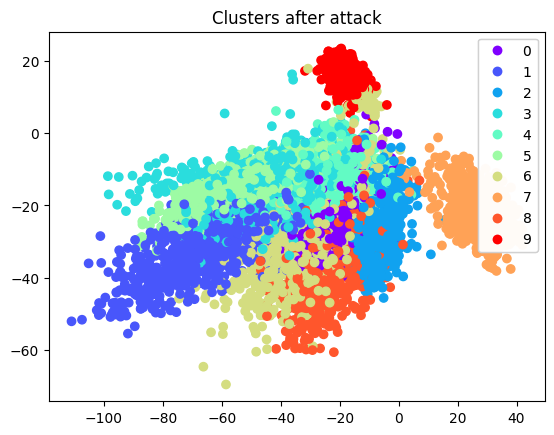

The execution time for the PCA defense is 164.23679423332214


In [ ]:
# Defense 1 - PCA
analyze_pca = pca_evaluate(model, trainloader)

Epoch: 1, Loss: 0.0054
Epoch: 2, Loss: 0.0028
Epoch: 3, Loss: 0.0045
Epoch: 4, Loss: 0.0015
Epoch: 5, Loss: 0.0048
Accuracy after KMeans defense for model: 99.17
Accuracy after KMeans defense for class (0): 99.48979591836735
Misclassification for KMeans: 0.5102040816326531
Accuracy after KMeans defense for class (1): 99.20704845814979
Misclassification for KMeans: 0.7929515418502202
Accuracy after KMeans defense for class (2): 98.83720930232558
Misclassification for KMeans: 1.1627906976744187
Accuracy after KMeans defense for class (3): 99.8019801980198
Misclassification for KMeans: 0.19801980198019803
Accuracy after KMeans defense for class (4): 99.79633401221996
Misclassification for KMeans: 0.20366598778004075
Accuracy after KMeans defense for class (5): 99.10313901345292
Misclassification for KMeans: 0.8968609865470852
Accuracy after KMeans defense for class (6): 99.26931106471817
Misclassification for KMeans: 0.7306889352818372
Accuracy after KMeans defense for class (7): 99.02723

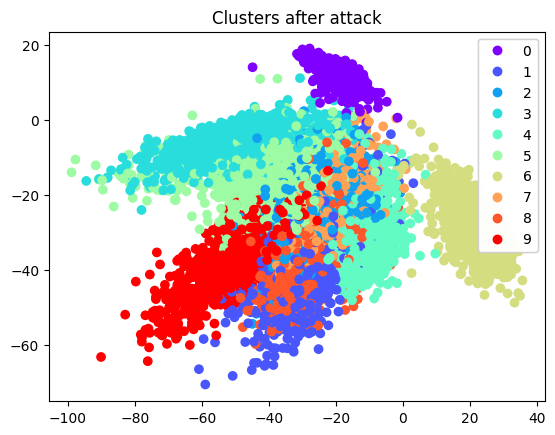

The execution time for the KMeans defense is 169.30808568000793


In [ ]:
# Defense 2 - KMeans
analyze_kmeans = kmeans_evaluate(model, trainloader)

Epoch: 1, Loss: 0.0060
Epoch: 2, Loss: 0.0042
Epoch: 3, Loss: 0.0045
Epoch: 4, Loss: 0.0037
Epoch: 5, Loss: 0.0028


<ipython-input-23-ec630f3822d7>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_after_combined.pth', map_location=torch.device('cpu

Overall Accuracy after combined defense: 99.05
Accuracy after combined defense for class 0: 99.6938775510204
Misclassification for Combined: 0.30612244897959184
Accuracy after combined defense for class 1: 99.29515418502203
Misclassification for Combined: 0.7048458149779736
Accuracy after combined defense for class 2: 99.8062015503876
Misclassification for Combined: 0.1937984496124031
Accuracy after combined defense for class 3: 98.91089108910892
Misclassification for Combined: 1.0891089108910892
Accuracy after combined defense for class 4: 99.38900203665987
Misclassification for Combined: 0.6109979633401222
Accuracy after combined defense for class 5: 97.75784753363229
Misclassification for Combined: 2.242152466367713
Accuracy after combined defense for class 6: 99.37369519832986
Misclassification for Combined: 0.6263048016701461
Accuracy after combined defense for class 7: 98.5408560311284
Misclassification for Combined: 1.4591439688715953
Accuracy after combined defense for class 8:

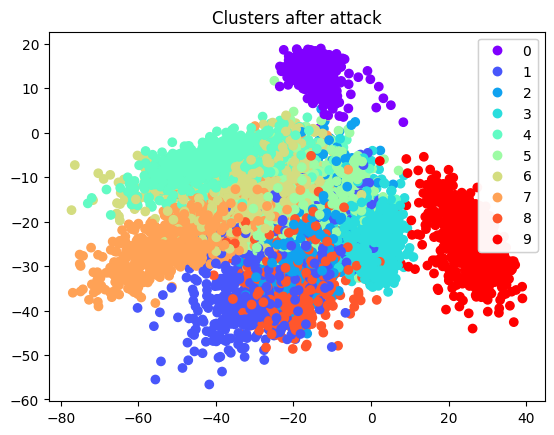

The execution time for the combined defense is 157.7929790019989


In [ ]:
# Defense 3 - Combined (PCA & KMeans)
analyze_combined = combined_evaluate(model, trainloader)